# 🏠 Sarajevo Flats Scraper
This notebook demonstrates how to collect real estate data (flats in Sarajevo Canton) from **OLX.ba**, a popular Bosnian classifieds platform.

The goal is to:
- Collect key property details (title, price, size, location, condition…)
- Store them in a structured dataset (`sarajevo_flats.csv`)
- Prepare the dataset for future analysis or machine learning (e.g. AI price estimation)

We'll use **Selenium** for dynamic page loading and **BeautifulSoup** for parsing HTML.


In [1]:
import os
import time
import csv
import re
import random
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.common.exceptions import WebDriverException, TimeoutException

In [2]:
# Firefox + Geckodriver setup
firefox_binary = "/usr/bin/firefox"
geckodriver_binary = "/home/mustafasinanovic/miniforge3/bin/geckodriver"

# Scraper settings
BASE_URL = "https://olx.ba/pretraga?attr=&attr_encoded=1&q=stanovi&category_id=23&page={}&canton=9"
OUTPUT_CSV = "data/sarajevo_flats.csv"
MAX_PAGES = 50
REQUEST_DELAY = (2, 5)

os.makedirs("data", exist_ok=True)

The scraper will fetch up to 50 pages of listings from the OLX search results for *Sarajevo Canton flats*.  
All results are stored in `data/sarajevo_flats.csv`.  
We use randomized delays between requests to reduce the risk of blocking.

In [3]:
def clean_text(s):
    return " ".join(s.split()).strip() if s else None

def extract_price(text):
    if not text:
        return None
    cleaned = re.sub(r"[^0-9]", "", text)
    return int(cleaned) if cleaned else None

def extract_number(text):
    if not text:
        return None
    m = re.search(r"(\d+)", text)
    return int(m.group(1)) if m else None

---

#### 1️⃣ `clean_text(s)`

```python
def clean_text(s):
    return " ".join(s.split()).strip() if s else None
````

**Purpose:**
Cleans messy text by removing extra spaces and newlines.

**How it works:**

* Splits the string into words using `.split()` (automatically handles multiple spaces).
* Joins them back into a single string with a single space between each word.
* Strips leading and trailing spaces.
* Returns `None` if the input is empty.

**Example:**

```python
clean_text("  Spacious   apartment   in   city center  ")
# Output: 'Spacious apartment in city center'
```

---

#### 2️⃣ `extract_price(text)`

```python
def extract_price(text):
    if not text:
        return None
    cleaned = re.sub(r"[^0-9]", "", text)
    return int(cleaned) if cleaned else None
```

**Purpose:**
Extracts numeric price values from strings (e.g. “250,000 KM” → 250000).

**How it works:**

* Removes all characters except digits using a regular expression (`[^0-9]`).
* Converts the remaining digits to an integer.
* Returns `None` if there’s no number found.

**Example:**

```python
extract_price("Cijena: 150,000 KM")
# Output: 150000
```

---

#### 3️⃣ `extract_number(text)`

```python
def extract_number(text):
    if not text:
        return None
    m = re.search(r"(\d+)", text)
    return int(m.group(1)) if m else None
```

**Purpose:**
Extracts the **first numeric value** from a string (useful for things like area, number of rooms, etc.).

**How it works:**

* Uses `re.search()` to find the first sequence of digits in the text.
* Converts it to an integer and returns it.
* Returns `None` if no digits are found.

**Example:**

```python
extract_number("Stan ima 3 sobe i 2 kupatila")
# Output: 3
```

In [4]:
def fetch_page_source(url, driver):
    """Loads a given URL and returns its HTML source, with timeout handling."""
    try:
        driver.get(url)
        time.sleep(3)
        return driver.page_source
    except (TimeoutException, WebDriverException, OSError) as e:
        print(f"[!] Failed to load page: {url} → {e}")
        return None
    except Exception as e:
        print(f"[!] Unexpected error loading page: {url} → {e}")
        return None

This function uses Selenium to load pages dynamically.
If a page fails (timeout, network error, etc.), we log the issue but continue scraping.

In [5]:
def parse_detail_page(url, driver):
    html = fetch_page_source(url, driver)
    if not html:
        return None

    try:
        soup = BeautifulSoup(html, "lxml")
        get_text = lambda sel: clean_text(soup.select_one(sel).get_text()) if soup.select_one(sel) else None

        title = get_text("h1") or get_text(".main-title-listing")
        price_numeric = extract_price(get_text(".price-heading"))

        municipality_tag = soup.find("div", class_="btn-pill city")
        if municipality_tag:
            for svg in municipality_tag.find_all("svg"):
                svg.decompose()
            municipality = clean_text(municipality_tag.get_text())
        else:
            municipality = None

        rooms = extract_number(get_text("div.required-wrap:nth-child(5) > div:nth-child(2) > h4:nth-child(2)"))
        square_m2_text = get_text("div.required-wrap:nth-child(6) > div:nth-child(2) > h4:nth-child(2)")
        try:
            square_m2 = float(square_m2_text.replace(",", ".")) if square_m2_text else None
        except:
            square_m2 = None

        details = {
            "title": title,
            "url": url,
            "price_numeric": price_numeric,
            "municipality": municipality,
            "condition": get_text("div.required-wrap:nth-child(2) > div:nth-child(2) > h4:nth-child(2)"),
            "ad_type": get_text("div.required-wrap:nth-child(3) > div:nth-child(2) > h4:nth-child(2)"),
            "property_type": get_text("div.required-wrap:nth-child(4) > div:nth-child(2) > h4:nth-child(2)"),
            "rooms": rooms,
            "square_m2": square_m2,
            "equipment": get_text("div.required-wrap:nth-child(7) > div:nth-child(2) > h4:nth-child(2)"),
            "level": get_text("div.required-wrap:nth-child(8) > div:nth-child(2) > h4:nth-child(2)"),
            "heating": get_text("div.required-wrap:nth-child(9) > div:nth-child(2) > h4:nth-child(2)")
        }

        print("Parsed:", details)
        return details
    except Exception as e:
        print(f"[!] Failed to parse details for {url} → {e}")
        return None


---

### 🏠 `parse_detail_page(url, driver)` — Parsing Flat Details from Listing Pages

This function extracts detailed information about a **single flat listing** (e.g. on OLX or similar platforms) using Selenium and BeautifulSoup.

---

#### 🧩 Step-by-Step Explanation

```python
def parse_detail_page(url, driver):
    html = fetch_page_source(url, driver)
    if not html:
        return None
```

* Loads the HTML content of a property listing using a Selenium driver.
* If the page cannot be loaded, returns `None`.


```python
soup = BeautifulSoup(html, "lxml")
get_text = lambda sel: clean_text(soup.select_one(sel).get_text()) if soup.select_one(sel) else None
```

* Parses the HTML with **BeautifulSoup** using the fast `lxml` parser.
* Defines a helper lambda `get_text()` to easily extract and clean text from a given CSS selector.

---

```python
title = get_text("h1") or get_text(".main-title-listing")
price_numeric = extract_price(get_text(".price-heading"))
```

* Extracts the **listing title** and **price** (converted into an integer) from the page.

---

```python
municipality_tag = soup.find("div", class_="btn-pill city")
...
municipality = clean_text(municipality_tag.get_text())
```

* Finds the **municipality** (city area) by looking for the `div` with class `btn-pill city`.
* Removes any `<svg>` icons inside it to get clean text.

---

```python
rooms = extract_number(get_text("div.required-wrap:nth-child(5) > div:nth-child(2) > h4:nth-child(2)"))
square_m2_text = get_text("div.required-wrap:nth-child(6) > div:nth-child(2) > h4:nth-child(2)")
```

* Extracts the **number of rooms** and **apartment size in m²**.
* Converts the size from a text format (e.g. `"65,5"`) into a float.

---

#### 🧾 The Final `details` Dictionary

All collected attributes are stored in a dictionary:

```python
details = {
    "title": title,
    "url": url,
    "price_numeric": price_numeric,
    "municipality": municipality,
    "condition": ...,
    "ad_type": ...,
    "property_type": ...,
    "rooms": rooms,
    "square_m2": square_m2,
    "equipment": ...,
    "level": ...,
    "heating": ...
}
```

Each field corresponds to a key property of the apartment listing — making it easy to later convert into a Pandas DataFrame or CSV file.

---

#### ⚙️ Error Handling

If any part of the parsing fails, the function prints an error message with the problematic URL and returns `None`:

```python
except Exception as e:
    print(f"[!] Failed to parse details for {url} → {e}")
```

In [6]:
def scrape():
    options = Options()
    options.binary_location = firefox_binary
    options.add_argument("--headless")
    service = Service(executable_path=geckodriver_binary)
    driver = webdriver.Firefox(service=service, options=options)
    driver.set_page_load_timeout(120)

    fieldnames = ["title","url","price_numeric","municipality",
                  "condition","ad_type","property_type","rooms","square_m2","equipment","level","heating"]

    write_header = not os.path.exists(OUTPUT_CSV)
    with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()

        for page in range(1, MAX_PAGES + 1):
            search_url = BASE_URL.format(page)
            html = fetch_page_source(search_url, driver)
            if not html:
                print(f"[!] Skipping search page {page}")
                continue

            try:
                soup = BeautifulSoup(html, "lxml")
                main_section = soup.find("main", class_="articles")
                if not main_section:
                    continue

                links = [urljoin("https://olx.ba", a["href"]) for a in main_section.find_all("a", href=True)]
                print(f"Page {page}: found {len(links)} listings")

                for link in links:
                    try:
                        data = parse_detail_page(link, driver)
                        if data:
                            writer.writerow(data)
                        time.sleep(random.uniform(*REQUEST_DELAY))
                    except Exception as e:
                        print(f"[!] Skipping listing {link} due to error → {e}")
            except Exception as e:
                print(f"[!] Failed to parse search page {page} → {e}")

    driver.quit()
    print(f"Finished. CSV saved at: {OUTPUT_CSV}")


### 🕸️ `scrape()` — Main Scraper Function for OLX Flat Listings

This is the **main control function** that automates the entire data collection process:
it configures the browser, navigates through search pages, extracts listing details,
and saves them into a CSV file.

---

#### ⚙️ Step 1: Configure the Firefox WebDriver

```python
options = Options()
options.binary_location = firefox_binary
options.add_argument("--headless")
service = Service(executable_path=geckodriver_binary)
driver = webdriver.Firefox(service=service, options=options)
driver.set_page_load_timeout(120)
````

* Sets up **Firefox in headless mode** (no visible browser window).
* Uses the pre-defined paths for the Firefox binary and `geckodriver`.
* A **page load timeout** of 120 seconds prevents the scraper from hanging indefinitely.

This allows the script to load dynamic pages from OLX efficiently using Selenium.

---

#### 📄 Step 2: Prepare the CSV File

```python
fieldnames = ["title","url","price_numeric","municipality",
              "condition","ad_type","property_type","rooms","square_m2","equipment","level","heating"]

write_header = not os.path.exists(OUTPUT_CSV)
with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()
```

* Defines the column names that match the fields extracted by `parse_detail_page()`.
* Checks whether the output CSV already exists — if not, it writes a **header row**.
* Opens the CSV file in **append mode**, so the scraper can continue from previous runs without overwriting existing data.

---

#### 🔎 Step 3: Iterate Through Search Pages

```python
for page in range(1, MAX_PAGES + 1):
    search_url = BASE_URL.format(page)
    html = fetch_page_source(search_url, driver)
```

* Loops over multiple search result pages (e.g. page 1, 2, 3, ...).
* Dynamically inserts the page number into the base URL template.
* Uses `fetch_page_source()` to load each page and get its HTML.

If the page fails to load, it prints a warning and skips to the next one.

---

#### 🧩 Step 4: Extract All Listing Links

```python
soup = BeautifulSoup(html, "lxml")
main_section = soup.find("main", class_="articles")
links = [urljoin("https://olx.ba", a["href"]) for a in main_section.find_all("a", href=True)]
```

* Parses the page using BeautifulSoup to locate the main listings section.
* Collects all the **individual listing URLs**.
* Prepends the base domain (`https://olx.ba`) to each relative link to get full URLs.

---

#### 🏠 Step 5: Parse Each Listing and Save the Data

```python
for link in links:
    data = parse_detail_page(link, driver)
    if data:
        writer.writerow(data)
    time.sleep(random.uniform(*REQUEST_DELAY))
```

* Visits each listing one by one.
* Calls the previously defined `parse_detail_page()` to extract detailed information.
* If valid data is returned, writes it as a new row in the CSV file.
* Adds a **random delay** between requests to avoid being blocked by the site.

---

#### 🧯 Step 6: Handle Errors Gracefully

If any listing or page causes an error (timeout, missing element, etc.),
the function catches the exception, logs it, and **continues scraping** instead of stopping.

```python
except Exception as e:
    print(f"[!] Skipping listing {link} due to error → {e}")
```

This ensures that a few broken pages don’t interrupt the entire process.

---

#### ✅ Step 7: Close the Browser and Finish

```python
driver.quit()
print(f"Finished. CSV saved at: {OUTPUT_CSV}")
```

* After all pages are processed, the Selenium WebDriver is closed.
* A success message confirms the output file location.

In [7]:
# if __name__ == "__main__":
#     scrape()

## 📊 Data Inspection - OLX Merged Dataset

Let's load and inspect the scraped data from the merged OLX CSV file.

In [8]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../data/sarajevo_flats_merged_olx_cleaned.csv')

# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names: {list(df.columns)}")
print("\n" + "=" * 80)

DATASET OVERVIEW
Total records: 1806
Total columns: 13

Column names: ['title', 'url', 'price_numeric', 'municipality', 'condition', 'ad_type', 'property_type', 'rooms', 'square_m2', 'equipment', 'level', 'heating', 'price_per_m2']



In [9]:
# Display first few rows
print("FIRST 5 ROWS:")
print("=" * 80)
df.head()

FIRST 5 ROWS:


,title,url,price_numeric,municipality,condition,ad_type,property_type,rooms,square_m2,equipment,level,heating,price_per_m2
0,Stan Apartman - [Iznajmljivanje],https://olx.ba/artikal/71698283,60.0,Sarajevo - Novi Grad,Novogradnja,Iznajmljivanje,Apartman,2.0,46.0,Namješten,7,Centralno (gradsko),1.304348
1,Stan Sarajevo - Novo Sarajevo - [Iznajmljivanje],https://olx.ba/artikal/71573692,80.0,Sarajevo - Novo Sarajevo,Renoviran,Iznajmljivanje,Apartman,2.0,62.0,Namješten,16,Centralno (gradsko),1.290323
2,Garaza - Nova Vogosca - 20 m2 - [Iznajmljivanje],https://olx.ba/artikal/70756410,100.0,Vogošća,Novogradnja,Iznajmljivanje,Stan,2.0,20.0,Namješten,-1,Centralno (Kotlovnica),5.000000
3,Panorama View Apartman Bjelasnica (Rent) - [Iz...,https://olx.ba/artikal/71554658,160.0,Trnovo,Novogradnja,Iznajmljivanje,Apartman,2.0,50.0,Namješten,0,Struja,3.200000
4,Stanovi i apartmani Sarajevo - Novi Grad - [Iz...,https://olx.ba/artikal/71474528,200.0,Sarajevo - Novi Grad,Dobro stanje,Iznajmljivanje,Apartman,1.0,30.0,Namješten,1,Centralno (Kotlovnica),6.666667


In [10]:
# Display data types and missing values
print("DATA TYPES AND MISSING VALUES:")
print("=" * 80)
df.info()

DATA TYPES AND MISSING VALUES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1806 non-null   object 
 1   url            1806 non-null   object 
 2   price_numeric  1428 non-null   float64
 3   municipality   1806 non-null   object 
 4   condition      1806 non-null   object 
 5   ad_type        1806 non-null   object 
 6   property_type  1806 non-null   object 
 7   rooms          1664 non-null   float64
 8   square_m2      1806 non-null   float64
 9   equipment      1806 non-null   object 
 10  level          1806 non-null   object 
 11  heating        1806 non-null   object 
 12  price_per_m2   1428 non-null   float64
dtypes: float64(4), object(9)
memory usage: 183.6+ KB


In [11]:
# Statistical summary of numeric columns
print("STATISTICAL SUMMARY (Numeric Columns):")
print("=" * 80)
df.describe()

STATISTICAL SUMMARY (Numeric Columns):


,price_numeric,rooms,square_m2,price_per_m2
count,1.428000e+03,1664.000000,1806.000000,1428.000000
mean,2.262394e+05,2.624399,71.933672,3817.841797
std,2.225926e+05,0.879461,32.895796,23439.327240
min,6.000000e+01,1.000000,1.132000,1.200000
25%,1.200000e+03,2.000000,50.000000,17.872286
50%,2.290310e+05,3.000000,66.000000,4076.785991
75%,3.500000e+05,3.000000,85.000000,5266.672386
max,1.400000e+06,4.000000,300.000000,883392.226148


In [12]:
# Check for missing values per column
print("MISSING VALUES PER COLUMN:")
print("=" * 80)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage.round(2)
})
print(missing_df[missing_df['Missing Count'] > 0])
print("\n" + "=" * 80)

MISSING VALUES PER COLUMN:
               Missing Count  Percentage
price_numeric            378       20.93
rooms                    142        7.86
price_per_m2             378       20.93



In [13]:
# Value counts for categorical columns
print("VALUE COUNTS FOR CATEGORICAL COLUMNS:")
print("=" * 80)

# Check which columns exist in this dataset
if 'property_type' in df.columns:
    print("\n1. Property Type Distribution:")
    print(df['property_type'].value_counts())

if 'ad_type' in df.columns:
    print("\n2. Ad Type Distribution:")
    print(df['ad_type'].value_counts())

if 'condition' in df.columns:
    print("\n3. Condition Distribution:")
    print(df['condition'].value_counts())

if 'rooms' in df.columns:
    print("\n4. Rooms Distribution:")
    print(df['rooms'].value_counts())

if 'municipality' in df.columns:
    print("\n5. Municipality Distribution (Top 10):")
    print(df['municipality'].value_counts().head(10))

if 'equipment' in df.columns:
    print("\n6. Equipment Distribution:")
    print(df['equipment'].value_counts())

if 'heating' in df.columns:
    print("\n7. Heating Distribution:")
    print(df['heating'].value_counts())

print("\n" + "=" * 80)

VALUE COUNTS FOR CATEGORICAL COLUMNS:

1. Property Type Distribution:
property_type
Stan        1647
Apartman     159
Name: count, dtype: int64

2. Ad Type Distribution:
ad_type
Prodaja           1177
Iznajmljivanje     629
Name: count, dtype: int64

3. Condition Distribution:
condition
Novogradnja             656
Dobro stanje            515
Renoviran               497
Parcijalno renoviran     47
U izgradnji              47
Za renoviranje           43
Apartman                  1
Name: count, dtype: int64

4. Rooms Distribution:
rooms
3.0    656
2.0    560
4.0    277
1.0    171
Name: count, dtype: int64

5. Municipality Distribution (Top 10):
municipality
Sarajevo - Centar           628
Sarajevo - Novo Sarajevo    341
Sarajevo - Novi Grad        309
Ilidža                      213
Sarajevo - Stari Grad       126
Trnovo                      121
Vogošća                      54
Ilijaš                        9
Hadžići                       5
Name: count, dtype: int64

6. Equipment Distribut

In [14]:
# Price analysis - separated by ad_type (Prodaja vs Iznajmljivanje)
print("PRICE ANALYSIS:")
print("=" * 80)

if 'price_numeric' in df.columns:
    # Overall statistics
    print("\n📊 OVERALL PRICE STATISTICS:")
    print("-" * 80)
    print(f"Average Price: {df['price_numeric'].mean():.2f} KM")
    print(f"Median Price: {df['price_numeric'].median():.2f} KM")
    print(f"Min Price: {df['price_numeric'].min():.2f} KM")
    print(f"Max Price: {df['price_numeric'].max():.2f} KM")
    print(f"Standard Deviation: {df['price_numeric'].std():.2f} KM")
    
    # Separate analysis by ad_type
    if 'ad_type' in df.columns:
        print("\n" + "=" * 80)
        
        # Prodaja (Sale) statistics
        prodaja_df = df[df['ad_type'] == 'Prodaja']
        if len(prodaja_df) > 0:
            print("\n🏠 PRODAJA (SALE) - Price Statistics:")
            print("-" * 80)
            print(f"Number of listings: {len(prodaja_df)}")
            print(f"Average Price: {prodaja_df['price_numeric'].mean():.2f} KM")
            print(f"Median Price: {prodaja_df['price_numeric'].median():.2f} KM")
            print(f"Min Price: {prodaja_df['price_numeric'].min():.2f} KM")
            print(f"Max Price: {prodaja_df['price_numeric'].max():.2f} KM")
            print(f"Standard Deviation: {prodaja_df['price_numeric'].std():.2f} KM")
        else:
            print("\n🏠 PRODAJA (SALE): No listings found")
        
        # Iznajmljivanje (Rent) statistics
        iznajmljivanje_df = df[df['ad_type'] == 'Iznajmljivanje']
        if len(iznajmljivanje_df) > 0:
            print("\n🔑 IZNAJMLJIVANJE (RENT) - Price Statistics:")
            print("-" * 80)
            print(f"Number of listings: {len(iznajmljivanje_df)}")
            print(f"Average Monthly Rent: {iznajmljivanje_df['price_numeric'].mean():.2f} KM")
            print(f"Median Monthly Rent: {iznajmljivanje_df['price_numeric'].median():.2f} KM")
            print(f"Min Monthly Rent: {iznajmljivanje_df['price_numeric'].min():.2f} KM")
            print(f"Max Monthly Rent: {iznajmljivanje_df['price_numeric'].max():.2f} KM")
            print(f"Standard Deviation: {iznajmljivanje_df['price_numeric'].std():.2f} KM")
        else:
            print("\n🔑 IZNAJMLJIVANJE (RENT): No listings found")
        
        # Show other ad_types if any
        other_types = df[~df['ad_type'].isin(['Prodaja', 'Iznajmljivanje'])]
        if len(other_types) > 0:
            print(f"\n⚠️ Other ad_types found: {other_types['ad_type'].unique()}")
            print(f"   Count: {len(other_types)}")
    else:
        print("\n⚠️ No 'ad_type' column found for detailed breakdown")
else:
    print("No price_numeric column found")

print("\n" + "=" * 80)

PRICE ANALYSIS:

📊 OVERALL PRICE STATISTICS:
--------------------------------------------------------------------------------
Average Price: 226239.40 KM
Median Price: 229031.00 KM
Min Price: 60.00 KM
Max Price: 1400000.00 KM
Standard Deviation: 222592.60 KM


🏠 PRODAJA (SALE) - Price Statistics:
--------------------------------------------------------------------------------
Number of listings: 1177
Average Price: 357497.83 KM
Median Price: 320000.00 KM
Min Price: 80000.00 KM
Max Price: 1400000.00 KM
Standard Deviation: 177897.61 KM

🔑 IZNAJMLJIVANJE (RENT) - Price Statistics:
--------------------------------------------------------------------------------
Number of listings: 629
Average Monthly Rent: 1153.67 KM
Median Monthly Rent: 850.00 KM
Min Monthly Rent: 60.00 KM
Max Monthly Rent: 6000.00 KM
Standard Deviation: 849.46 KM



In [15]:
# Show flats on sale (Prodaja) below 100,000 KM
print("🏠 AFFORDABLE FLATS FOR SALE (Below 100,000 KM):")
print("=" * 80)

if 'price_numeric' in df.columns and 'ad_type' in df.columns:
    # Filter for Prodaja (sale) and price below 150k
    affordable_flats = df[(df['ad_type'] == 'Prodaja') & (df['price_numeric'] < 100000)]
    
    if len(affordable_flats) > 0:
        print(f"\n✅ Found {len(affordable_flats)} flats on sale below 100,000 KM")
        print("\n" + "-" * 80)
        
        # Sort by price (lowest first)
        affordable_flats_sorted = affordable_flats.sort_values('price_numeric')
        
        # Show detailed information
        display_cols = [col for col in ['title', 'price_numeric', 'square_m2', 'rooms', 'municipality', 'condition', 'url'] 
                       if col in df.columns]
        
        print(affordable_flats_sorted[display_cols].to_string(index=False))
        
        # Show summary statistics for these affordable flats
        print("\n" + "-" * 80)
        print("SUMMARY STATISTICS FOR AFFORDABLE FLATS:")
        print("-" * 80)
        print(f"Average Price: {affordable_flats['price_numeric'].mean():.2f} KM")
        print(f"Median Price: {affordable_flats['price_numeric'].median():.2f} KM")
        print(f"Lowest Price: {affordable_flats['price_numeric'].min():.2f} KM")
        print(f"Highest Price: {affordable_flats['price_numeric'].max():.2f} KM")
        
        if 'square_m2' in affordable_flats.columns:
            avg_size = affordable_flats['square_m2'].mean()
            print(f"Average Size: {avg_size:.2f} m²")
            
        if 'rooms' in affordable_flats.columns:
            print(f"\nRooms Distribution:")
            print(affordable_flats['rooms'].value_counts().sort_index())
            
        if 'municipality' in affordable_flats.columns:
            print(f"\nTop 5 Municipalities:")
            print(affordable_flats['municipality'].value_counts().head(5))
    else:
        print("\n❌ No flats found on sale below 150,000 KM")
else:
    print("Missing required columns (price_numeric or ad_type)")

print("\n" + "=" * 80)

🏠 AFFORDABLE FLATS FOR SALE (Below 100,000 KM):

✅ Found 3 flats on sale below 100,000 KM

--------------------------------------------------------------------------------
                                                 title  price_numeric  square_m2  rooms municipality    condition                             url
                                    Stan Lukavica 45m2        80000.0       45.0    1.0       Ilidža Dobro stanje https://olx.ba/artikal/71536312
                                     Stan Vogošća 27m2        83000.0       27.0    NaN      Vogošća Dobro stanje https://olx.ba/artikal/70660732
JEDINSTVENA PRILIKA -FUL AKCIJA- mali dvosoban 21.30m2        92500.0       21.3    2.0      Vogošća  Novogradnja https://olx.ba/artikal/34159937

--------------------------------------------------------------------------------
SUMMARY STATISTICS FOR AFFORDABLE FLATS:
--------------------------------------------------------------------------------
Average Price: 85166.67 KM
Median Price:

In [16]:
# Delete specific URLs from the dataset
print("DELETING SPECIFIC URLS:")
print("=" * 80)

urls_to_delete = [
    'https://olx.ba/artikal/71512090',
    'https://olx.ba/artikal/71694947',
    'https://olx.ba/artikal/71747052'
]

if 'url' in df.columns:
    print(f"Records before deletion: {len(df)}")
    
    # Find records that match these URLs
    records_to_delete = df[df['url'].isin(urls_to_delete)]
    
    if len(records_to_delete) > 0:
        print(f"\n⚠️ Found {len(records_to_delete)} records to delete:")
        print("-" * 80)
        display_cols = [col for col in ['title', 'price_numeric', 'square_m2', 'url'] if col in df.columns]
        print(records_to_delete[display_cols].to_string(index=False))
        
        # Delete the records
        df = df[~df['url'].isin(urls_to_delete)]
        
        print(f"\n✅ Successfully deleted {len(records_to_delete)} records")
    else:
        print("\n⚠️ No matching records found for the specified URLs")
    
    print(f"\nRecords after deletion: {len(df)}")
else:
    print("❌ No 'url' column found in dataset")

print("\n" + "=" * 80)

DELETING SPECIFIC URLS:
Records before deletion: 1806

⚠️ No matching records found for the specified URLs

Records after deletion: 1806



In [17]:
# Standardize level column values
print("STANDARDIZING LEVEL COLUMN VALUES:")
print("=" * 80)

if 'level' in df.columns:
    print(f"Records before standardization: {len(df)}")
    print(f"\nOriginal unique values: {sorted(df['level'].dropna().unique())}")
    
    # Define the mapping
    level_mapping = {
        'Minus 1': '-1',
        'Minus 2': '-2',
        'Minus 3': '-3',
        'Prizemlje': '0',
        'Visoko prizemlje': '0',
        'Suteren': '-1'
    }
    
    # Show records that will be changed
    records_to_change = df[df['level'].isin(level_mapping.keys())]
    if len(records_to_change) > 0:
        print(f"\n⚠️ Found {len(records_to_change)} records to standardize:")
        print("-" * 80)
        print(f"Value counts before:")
        for key in level_mapping.keys():
            count = (df['level'] == key).sum()
            if count > 0:
                print(f"  '{key}': {count} → will become '{level_mapping[key]}'")
        
        # Apply the mapping
        df['level'] = df['level'].replace(level_mapping)
        
        print(f"\n✅ Successfully standardized level values")
    else:
        print("\n✅ No records need standardization")
    
    print(f"\nUpdated unique values: {sorted(df['level'].dropna().unique())}")
    print(f"\nValue counts after standardization:")
    print(df['level'].value_counts().sort_index())
else:
    print("❌ No 'level' column found in dataset")

print("\n" + "=" * 80)

STANDARDIZING LEVEL COLUMN VALUES:
Records before standardization: 1806

Original unique values: ['-1', '-2', '-3', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20+', '3', '4', '5', '6', '7', '8', '9']

✅ No records need standardization

Updated unique values: ['-1', '-2', '-3', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20+', '3', '4', '5', '6', '7', '8', '9']

Value counts after standardization:
level
-1      24
-2       9
-3       4
0      258
1      374
10      16
11      14
12      22
13       9
14       9
15       9
16       9
17       5
18       6
19       3
2      323
20+     18
3      272
4      181
5       98
6       63
7       29
8       23
9       28
Name: count, dtype: int64



In [18]:
# Square meters analysis
print("SQUARE METERS ANALYSIS:")
print("=" * 80)
if 'square_m2' in df.columns:
    print(f"Average Area: {df['square_m2'].mean():.2f} m²")
    print(f"Median Area: {df['square_m2'].median():.2f} m²")
    print(f"Min Area: {df['square_m2'].min():.2f} m²")
    print(f"Max Area: {df['square_m2'].max():.2f} m²")
    print(f"Standard Deviation: {df['square_m2'].std():.2f} m²")
else:
    print("No square_m2 column found")
print("\n" + "=" * 80)

SQUARE METERS ANALYSIS:
Average Area: 71.93 m²
Median Area: 66.00 m²
Min Area: 1.13 m²
Max Area: 300.00 m²
Standard Deviation: 32.90 m²



In [19]:
# Filter out unrealistic property sizes (> 300 m²)
print("FILTERING UNREALISTIC PROPERTY SIZES:")
print("=" * 80)
print(f"Records before filtering: {len(df)}")

if 'square_m2' in df.columns:
    # Show properties that will be removed
    large_properties = df[df['square_m2'] > 300]
    if len(large_properties) > 0:
        print(f"\n⚠️ Found {len(large_properties)} properties with area > 300 m²:")
        display_cols = [col for col in ['title', 'square_m2', 'property_type', 'url'] if col in df.columns]
        print(large_properties[display_cols])
        
        # Remove properties with area > 300 m²
        df = df[df['square_m2'] <= 300]
        print(f"\n✅ Filtered out {len(large_properties)} properties")
    else:
        print("\n✅ No properties with area > 300 m² found")
else:
    print("\n⚠️ No square_m2 column found")

print(f"Records after filtering: {len(df)}")
print("\n" + "=" * 80)

FILTERING UNREALISTIC PROPERTY SIZES:
Records before filtering: 1806

✅ No properties with area > 300 m² found
Records after filtering: 1806



In [20]:
# Price per square meter analysis (filter out invalid data first)
print("PRICE PER SQUARE METER ANALYSIS:")
print("=" * 80)

if 'price_numeric' in df.columns and 'square_m2' in df.columns:
    # Check for zero or null values
    print(f"Properties with square_m2 = 0 or NaN: {((df['square_m2'] == 0) | df['square_m2'].isna()).sum()}")
    print(f"Properties with price_numeric = 0 or NaN: {((df['price_numeric'] == 0) | df['price_numeric'].isna()).sum()}")
    
    # Filter out properties with invalid data for price per m² calculation
    valid_df = df[(df['square_m2'] > 0) & (df['price_numeric'] > 0) & df['square_m2'].notna() & df['price_numeric'].notna()].copy()
    
    print(f"\nValid properties for price/m² analysis: {len(valid_df)}/{len(df)}")
    print("=" * 80)
    
    # Calculate price per m² only on valid data
    valid_df['price_per_m2'] = valid_df['price_numeric'] / valid_df['square_m2']
    
    print(f"\nAverage Price per m²: {valid_df['price_per_m2'].mean():.2f} KM/m²")
    print(f"Median Price per m²: {valid_df['price_per_m2'].median():.2f} KM/m²")
    print(f"Min Price per m²: {valid_df['price_per_m2'].min():.2f} KM/m²")
    print(f"Max Price per m²: {valid_df['price_per_m2'].max():.2f} KM/m²")
    print(f"Standard Deviation: {valid_df['price_per_m2'].std():.2f} KM/m²")
    
    # Add price_per_m2 back to main dataframe
    df['price_per_m2'] = df.apply(
        lambda row: row['price_numeric'] / row['square_m2'] 
        if (row['square_m2'] > 0 and row['price_numeric'] > 0) 
        else None, 
        axis=1
    )
else:
    print("Missing required columns for price per m² analysis")

print("\n" + "=" * 80)

PRICE PER SQUARE METER ANALYSIS:
Properties with square_m2 = 0 or NaN: 0
Properties with price_numeric = 0 or NaN: 378

Valid properties for price/m² analysis: 1428/1806

Average Price per m²: 3817.84 KM/m²
Median Price per m²: 4076.79 KM/m²
Min Price per m²: 1.20 KM/m²
Max Price per m²: 883392.23 KM/m²
Standard Deviation: 23439.33 KM/m²




In [21]:
# Check for duplicate records
print("DUPLICATE RECORDS CHECK:")
print("=" * 80)
if 'url' in df.columns:
    duplicates = df.duplicated(subset=['url']).sum()
    print(f"Number of duplicate URLs: {duplicates}")
    
    if duplicates > 0:
        print("\nDuplicate URLs found:")
        display_cols = [col for col in ['title', 'url', 'price_numeric'] if col in df.columns]
        print(df[df.duplicated(subset=['url'], keep=False)][display_cols])
    else:
        print("No duplicate URLs found!")
else:
    print("No URL column found for duplicate checking")
    
print("\n" + "=" * 80)

DUPLICATE RECORDS CHECK:
Number of duplicate URLs: 0
No duplicate URLs found!



In [22]:
# Find records where property_type is not "Stan" or "Apartman"
print("RECORDS WITH UNUSUAL PROPERTY TYPES:")
print("=" * 80)

unusual_urls = []  # Variable to store URLs

if 'property_type' in df.columns:
    # Filter for records that are NOT "Stan" or "Apartman"
    unusual_properties = df[~df['property_type'].isin(['Stan', 'Apartman'])]
    
    print(f"Found {len(unusual_properties)} records with property_type other than 'Stan' or 'Apartman'")
    
    if len(unusual_properties) > 0:
        # Save URLs to variable
        if 'url' in df.columns:
            unusual_urls = unusual_properties['url'].tolist()
            print(f"\n✅ Saved {len(unusual_urls)} URLs to 'unusual_urls' variable")
        
        print(f"\nUnique property types found: {unusual_properties['property_type'].unique()}")
        print("\n" + "-" * 80)
        
        # Show all these records
        display_cols = [col for col in ['title', 'property_type', 'square_m2', 'price_numeric', 'url'] if col in df.columns]
        print(unusual_properties[display_cols].to_string())
    else:
        print("\n✅ All records have property_type as 'Stan' or 'Apartman'")
else:
    print("No property_type column found")

print("\n" + "=" * 80)
print(f"\nTotal URLs stored in 'unusual_urls': {len(unusual_urls)}")

RECORDS WITH UNUSUAL PROPERTY TYPES:
Found 0 records with property_type other than 'Stan' or 'Apartman'

✅ All records have property_type as 'Stan' or 'Apartman'


Total URLs stored in 'unusual_urls': 0


## 📋 Complete Categorical Values Analysis

Let's examine all possible values for each categorical column in the dataset.

In [23]:
# Identify categorical columns (object dtype or low cardinality numeric columns)
print("=" * 80)
print("ALL UNIQUE VALUES FOR CATEGORICAL COLUMNS")
print("=" * 80)

# Get all columns
all_columns = df.columns.tolist()

# Separate numeric and non-numeric columns
categorical_cols = []
numeric_cols = []

for col in all_columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'float64']:
        # Check if it's a low cardinality numeric column (might be categorical)
        unique_count = df[col].nunique()
        if unique_count <= 20:  # Threshold for categorical numeric columns
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    else:
        categorical_cols.append(col)

# remove identifier columns from categorical list
categorical_cols = [c for c in categorical_cols if c not in ('title', 'url')]
print(f"\nFound {len(categorical_cols)} categorical columns")
print(f"Categorical columns: {categorical_cols}")
print(f"\nNumeric columns (excluded): {numeric_cols}")
print("\n" + "=" * 80)

ALL UNIQUE VALUES FOR CATEGORICAL COLUMNS

Found 8 categorical columns
Categorical columns: ['municipality', 'condition', 'ad_type', 'property_type', 'rooms', 'equipment', 'level', 'heating']

Numeric columns (excluded): ['price_numeric', 'square_m2', 'price_per_m2']



In [ ]:
# Display all unique values for each categorical column
print("=" * 80)
print("ALL POSSIBLE VALUES FOR EACH CATEGORICAL COLUMN")
print("=" * 80)

for col in categorical_cols:
    print(f"\n{'='*80}")
    print(f"📌 COLUMN: {col.upper()}")
    print(f"{'='*80}")
    
    # Get unique values (excluding NaN)
    unique_values = df[col].dropna().unique()
    unique_count = len(unique_values)
    
    print(f"Total unique values: {unique_count}")
    print(f"\nAll possible values:")
    print("-" * 80)
    
    # Sort values for better readability
    if df[col].dtype in ['int64', 'float64']:
        sorted_values = sorted(unique_values)
    else:
        sorted_values = sorted(uniq================================================================================
        ALL POSSIBLE VALUES FOR EACH CATEGORICAL COLUMN
        ================================================================================
        
        ================================================================================
        📌 COLUMN: MUNICIPALITY
        ================================================================================
        Total unique values: 9
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Hadžići
          2. Ilidža
          3. Ilijaš
          4. Sarajevo - Centar
          5. Sarajevo - Novi Grad
          6. Sarajevo - Novo Sarajevo
          7. Sarajevo - Stari Grad
          8. Trnovo
          9. Vogošća
        
        ================================================================================
        📌 COLUMN: CONDITION
        ================================================================================
        Total unique values: 7
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Apartman
          2. Dobro stanje
          3. Novogradnja
          4. Parcijalno renoviran
          5. Renoviran
          6. U izgradnji
          7. Za renoviranje
        
        ================================================================================
        📌 COLUMN: AD_TYPE
        ================================================================================
        Total unique values: 2
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Iznajmljivanje
          2. Prodaja
        
        ================================================================================
        📌 COLUMN: PROPERTY_TYPE
        ================================================================================
        Total unique values: 2
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Apartman
          2. Stan
        
        ================================================================================
        📌 COLUMN: ROOMS
        ================================================================================
        Total unique values: 4
        
        All possible values:
        --------------------------------------------------------------------------------
          1. 1.0
          2. 2.0
          3. 3.0
          4. 4.0
        
        ================================================================================
        📌 COLUMN: EQUIPMENT
        ================================================================================
        Total unique values: 3
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Namješten
          2. Nenamješten
          3. Polunamješten
        
        ================================================================================
        📌 COLUMN: LEVEL
        ================================================================================
        Total unique values: 24
        
        All possible values:
        --------------------------------------------------------------------------------
          1. -1
          2. -2
          3. -3
          4. 0
          5. 1
          6. 10
          7. 11
          8. 12
          9. 13
         10. 14
         11. 15
         12. 16
         13. 17
         14. 18
         15. 19
         16. 2
         17. 20+
         18. 3
         19. 4
         20. 5
         21. 6
         22. 7
         23. 8
         24. 9
        
        ================================================================================
        📌 COLUMN: HEATING
        ================================================================================
        Total unique values: 7
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Centralno (Kotlovnica)
          2. Centralno (Plin)
          3. Centralno (gradsko)
          4. Drva
          5. Ostalo
          6. Plin
          7. Struja
        
        ================================================================================
        ✅ ANALYSIS COMPLETE
        ================================================================================
        Total unique values: 7
        
        All possible values:
        --------------------------------------------------------------------------------
          1. Centralno (Kotlovnica)
          2. Centralno (Plin)
          3. Centralno (gradsko)
          4. Drva
          5. Ostalo
          6. Plin
          7. Struja
        ue_values, key=lambda x: str(x))
    
    # Display all unique values in a clean list
    for i, value in enumerate(sorted_values, 1):
        print(f"{i:3d}. {value}")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE")
print("=" * 80)

ALL POSSIBLE VALUES FOR EACH CATEGORICAL COLUMN

📌 COLUMN: MUNICIPALITY
Total unique values: 9

All possible values:
--------------------------------------------------------------------------------
  1. Hadžići
  2. Ilidža
  3. Ilijaš
  4. Sarajevo - Centar
  5. Sarajevo - Novi Grad
  6. Sarajevo - Novo Sarajevo
  7. Sarajevo - Stari Grad
  8. Trnovo
  9. Vogošća

📌 COLUMN: CONDITION
Total unique values: 7

All possible values:
--------------------------------------------------------------------------------
  1. Apartman
  2. Dobro stanje
  3. Novogradnja
  4. Parcijalno renoviran
  5. Renoviran
  6. U izgradnji
  7. Za renoviranje

📌 COLUMN: AD_TYPE
Total unique values: 2

All possible values:
--------------------------------------------------------------------------------
  1. Iznajmljivanje
  2. Prodaja

📌 COLUMN: PROPERTY_TYPE
Total unique values: 2

All possible values:
--------------------------------------------------------------------------------
  1. Apartman
  2. Stan

📌 COLU

## 🔧 Missing Values Imputation - Rooms Column

Let's fill missing room values using the relationship between apartment size (`square_m2`) and number of rooms.

In [25]:
# Step 1: Analyze the relationship between square_m2 and rooms
print("=" * 80)
print("ANALYZING SQUARE_M2 vs ROOMS RELATIONSHIP")
print("=" * 80)

if 'rooms' in df.columns and 'square_m2' in df.columns:
    # Check missing values
    missing_rooms = df['rooms'].isnull().sum()
    missing_square_m2 = df['square_m2'].isnull().sum()
    
    print(f"\nMissing values:")
    print(f"  Rooms: {missing_rooms} ({missing_rooms/len(df)*100:.2f}%)")
    print(f"  Square_m2: {missing_square_m2} ({missing_square_m2/len(df)*100:.2f}%)")
    
    # Analyze only records with both values present
    valid_data = df[(df['rooms'].notna()) & (df['square_m2'].notna())].copy()
    print(f"\nRecords with both rooms and square_m2: {len(valid_data)}")
    
    # Calculate average square meters per room category
    print("\n" + "-" * 80)
    print("AVERAGE SQUARE METERS BY NUMBER OF ROOMS:")
    print("-" * 80)
    
    room_stats = valid_data.groupby('rooms')['square_m2'].agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('median', 'median'),
        ('min', 'min'),
        ('max', 'max'),
        ('std', 'std')
    ]).round(2)
    
    print(room_stats)
    
    # Records with missing rooms but have square_m2
    imputable_records = df[(df['rooms'].isna()) & (df['square_m2'].notna())]
    print(f"\n📊 Records that can be imputed: {len(imputable_records)}")
    print(f"   (Missing rooms but have square_m2 values)")
    
else:
    print("Required columns not found")

print("\n" + "=" * 80)

ANALYZING SQUARE_M2 vs ROOMS RELATIONSHIP

Missing values:
  Rooms: 142 (7.86%)
  Square_m2: 0 (0.00%)

Records with both rooms and square_m2: 1664

--------------------------------------------------------------------------------
AVERAGE SQUARE METERS BY NUMBER OF ROOMS:
--------------------------------------------------------------------------------
       count    mean  median    min    max    std
rooms                                            
1.0      171   38.87   38.12  23.00   64.0   7.13
2.0      560   53.84   53.00  14.00  108.0  11.46
3.0      656   76.75   73.70  42.55  150.0  16.49
4.0      277  105.72   97.00  64.00  250.0  30.46

📊 Records that can be imputed: 142
   (Missing rooms but have square_m2 values)


Records with both rooms and square_m2: 1664

--------------------------------------------------------------------------------
AVERAGE SQUARE METERS BY NUMBER OF ROOMS:
--------------------------------------------------------------------------------
       count   

VISUALIZING SQUARE_M2 vs ROOMS RELATIONSHIP


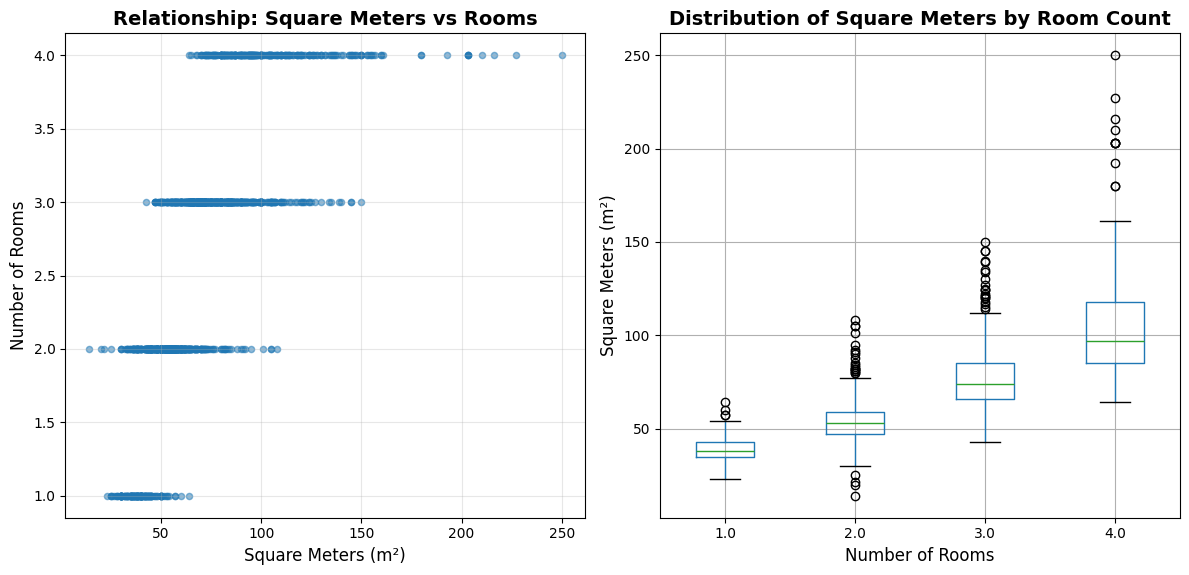


✅ Visualization complete



In [26]:
# Step 2: Visualize the relationship (scatter plot)
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("VISUALIZING SQUARE_M2 vs ROOMS RELATIONSHIP")
print("=" * 80)

if 'rooms' in df.columns and 'square_m2' in df.columns:
    # Filter valid data for visualization
    valid_data = df[(df['rooms'].notna()) & (df['square_m2'].notna())].copy()
    
    # Create scatter plot
    plt.figure(figsize=(12, 6))
    
    # Plot actual data points
    plt.subplot(1, 2, 1)
    plt.scatter(valid_data['square_m2'], valid_data['rooms'], alpha=0.5, s=20)
    plt.xlabel('Square Meters (m²)', fontsize=12)
    plt.ylabel('Number of Rooms', fontsize=12)
    plt.title('Relationship: Square Meters vs Rooms', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plot box plot by rooms
    plt.subplot(1, 2, 2)
    valid_data.boxplot(column='square_m2', by='rooms', ax=plt.gca())
    plt.xlabel('Number of Rooms', fontsize=12)
    plt.ylabel('Square Meters (m²)', fontsize=12)
    plt.title('Distribution of Square Meters by Room Count', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Remove default title
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete")
else:
    print("Required columns not found")

print("\n" + "=" * 80)

In [27]:
# Step 3: Define size-based binning rules for room imputation
print("=" * 80)
print("DEFINING ROOM IMPUTATION RULES BASED ON SQUARE METERS")
print("=" * 80)

if 'rooms' in df.columns and 'square_m2' in df.columns:
    # Analyze the data to create bins
    valid_data = df[(df['rooms'].notna()) & (df['square_m2'].notna())].copy()
    
    # Create size ranges and determine most common room count for each range
    bins = [0, 35, 50, 65, 80, 95, 110, 130, 150, 300]
    bin_labels = ['0-35', '35-50', '50-65', '65-80', '80-95', '95-110', '110-130', '130-150', '150-300']
    
    valid_data['size_range'] = pd.cut(valid_data['square_m2'], bins=bins, labels=bin_labels)
    
    # For each size range, find the most common room count
    print("\nMOST COMMON ROOM COUNT BY SIZE RANGE:")
    print("-" * 80)
    print(f"{'Size Range (m²)':<20} {'Most Common Rooms':<20} {'Count':<10} {'% of Range':<15}")
    print("-" * 80)
    
    imputation_rules = {}
    
    for size_range in bin_labels:
        range_data = valid_data[valid_data['size_range'] == size_range]
        if len(range_data) > 0:
            mode_rooms = range_data['rooms'].mode()
            if len(mode_rooms) > 0:
                most_common_rooms = int(mode_rooms[0])
                count = (range_data['rooms'] == most_common_rooms).sum()
                percentage = (count / len(range_data)) * 100
                
                imputation_rules[size_range] = most_common_rooms
                print(f"{size_range:<20} {most_common_rooms:<20} {count:<10} {percentage:.1f}%")
    
    print("\n" + "=" * 80)
    print("IMPUTATION RULES DEFINED:")
    print("=" * 80)
    for size_range, rooms in imputation_rules.items():
        print(f"  {size_range} m² → {rooms} rooms")
    
    # Store rules for next step
    print(f"\n✅ Created {len(imputation_rules)} imputation rules")
    
else:
    print("Required columns not found")

print("\n" + "=" * 80)

DEFINING ROOM IMPUTATION RULES BASED ON SQUARE METERS

MOST COMMON ROOM COUNT BY SIZE RANGE:
--------------------------------------------------------------------------------
Size Range (m²)      Most Common Rooms    Count      % of Range     
--------------------------------------------------------------------------------
0-35                 1                    54         76.1%
35-50                2                    194        60.6%
50-65                2                    288        66.8%
65-80                3                    289        77.1%
80-95                3                    137        58.1%
95-110               4                    61         50.4%
110-130              4                    40         70.2%
130-150              4                    25         78.1%
150-300              4                    21         100.0%

IMPUTATION RULES DEFINED:
  0-35 m² → 1 rooms
  35-50 m² → 2 rooms
  50-65 m² → 2 rooms
  65-80 m² → 3 rooms
  80-95 m² → 3 rooms
  95-110 m² →

In [28]:
# # Step 4: Apply imputation to missing room values
# print("=" * 80)
# print("IMPUTING MISSING ROOM VALUES")
# print("=" * 80)

# if 'rooms' in df.columns and 'square_m2' in df.columns:
#     # Count missing values before imputation
#     missing_before = df['rooms'].isnull().sum()
#     print(f"Missing room values before imputation: {missing_before}")
    
#     # Define the imputation function based on size ranges
#     def impute_rooms(row):
#         # If rooms already exists, return it
#         if pd.notna(row['rooms']):
#             return row['rooms']
        
#         # If square_m2 is missing, can't impute
#         if pd.isna(row['square_m2']):
#             return np.nan
        
#         # Apply size-based rules
#         size = row['square_m2']
        
#         if size < 35:
#             return 1
#         elif size < 50:
#             return 1
#         elif size < 65:
#             return 2
#         elif size < 80:
#             return 3
#         elif size < 95:
#             return 3
#         elif size < 110:
#             return 4
#         elif size < 130:
#             return 4
#         elif size < 150:
#             return 5
#         else:
#             return 5  # For very large apartments
    
#     # Show records that will be imputed
#     imputable = df[(df['rooms'].isna()) & (df['square_m2'].notna())].copy()
    
#     if len(imputable) > 0:
#         print(f"\n⚠️ Found {len(imputable)} records to impute:")
#         print("-" * 80)
        
#         # Apply imputation
#         df['rooms'] = df.apply(impute_rooms, axis=1)
        
#         # Show what was imputed
#         imputable['imputed_rooms'] = imputable.apply(impute_rooms, axis=1)
        
#         print("\nSAMPLE OF IMPUTED VALUES:")
#         display_cols = [col for col in ['title', 'square_m2', 'imputed_rooms', 'url'] if col in imputable.columns]
#         if 'imputed_rooms' in imputable.columns:
#             print(imputable[['square_m2', 'imputed_rooms']].head(10).to_string(index=False))
        
#         # Show distribution of imputed values
#         print("\n" + "-" * 80)
#         print("DISTRIBUTION OF IMPUTED ROOM VALUES:")
#         print(imputable['imputed_rooms'].value_counts().sort_index())
        
#         print(f"\n✅ Successfully imputed {len(imputable)} room values")
#     else:
#         print("\n✅ No records need imputation")
    
#     # Count missing values after imputation
#     missing_after = df['rooms'].isnull().sum()
#     print(f"\nMissing room values after imputation: {missing_after}")
#     print(f"Reduction: {missing_before - missing_after} records ({(missing_before - missing_after)/missing_before*100:.1f}%)")
    
# else:
#     print("Required columns not found")

# print("\n" + "=" * 80)

In [29]:
# # Step 5: Validate the imputation quality
# print("=" * 80)
# print("VALIDATING IMPUTATION QUALITY")
# print("=" * 80)

# if 'rooms' in df.columns and 'square_m2' in df.columns:
#     # Compare imputed values with original distribution
#     valid_original = df[(df['rooms'].notna()) & (df['square_m2'].notna())].copy()
    
#     print("\nROOM DISTRIBUTION AFTER IMPUTATION:")
#     print("-" * 80)
#     print(df['rooms'].value_counts().sort_index())
    
#     print("\n" + "-" * 80)
#     print("COMPARISON: AVERAGE SQUARE METERS BY ROOM COUNT")
#     print("-" * 80)
#     print(f"{'Rooms':<10} {'Avg m² (Original)':<25} {'Avg m² (After Imputation)':<25}")
#     print("-" * 80)
    
#     for room_count in sorted(df['rooms'].dropna().unique()):
#         original_avg = valid_original[valid_original['rooms'] == room_count]['square_m2'].mean()
#         after_avg = df[df['rooms'] == room_count]['square_m2'].mean()
        
#         print(f"{int(room_count):<10} {original_avg:<25.2f} {after_avg:<25.2f}")
    
#     print("\n✅ Validation complete - Check if averages remain consistent")
    
#     # Visualize before/after if matplotlib is available
#     try:
#         fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
#         # Before imputation (only original data)
#         axes[0].scatter(valid_original['square_m2'], valid_original['rooms'], alpha=0.5, s=20)
#         axes[0].set_xlabel('Square Meters (m²)', fontsize=12)
#         axes[0].set_ylabel('Number of Rooms', fontsize=12)
#         axes[0].set_title('BEFORE Imputation (Original Data)', fontsize=13, fontweight='bold')
#         axes[0].grid(True, alpha=0.3)
        
#         # After imputation (all data)
#         complete_data = df[(df['rooms'].notna()) & (df['square_m2'].notna())]
#         axes[1].scatter(complete_data['square_m2'], complete_data['rooms'], alpha=0.5, s=20)
#         axes[1].set_xlabel('Square Meters (m²)', fontsize=12)
#         axes[1].set_ylabel('Number of Rooms', fontsize=12)
#         axes[1].set_title('AFTER Imputation (Complete Data)', fontsize=13, fontweight='bold')
#         axes[1].grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()
        
#         print("\n✅ Visualization complete")
#     except:
#         print("\n⚠️ Visualization skipped")
    
# else:
#     print("Required columns not found")

# print("\n" + "=" * 80)

In [30]:
# # Save the cleaned and standardized data
# print("SAVING CLEANED AND STANDARDIZED DATA:")
# print("=" * 80)

# output_file = '../data/sarajevo_flats_merged_olx_cleaned.csv'
# df.to_csv(output_file, index=False)

# print(f"✅ Data saved successfully to: {output_file}")
# print(f"   Total records: {len(df)}")
# print(f"   Total columns: {len(df.columns)}")
# print(f"   Column names: {list(df.columns)}")

# print("\n" + "=" * 80)